## Kmean clustering example with BigQuery ML.

There are many ways to cluster customer segmentations for the business purpose. Kmeans is one of favorite one to make this customer segmentations. 

With public dataset in bigquery, we will make a right customer segmentation group under BigQuery Machine learning. 

At first, we will prepare target dataset to analyze.

In the 'bigquery-public-data' section, you can choose 'google_analytics_sample'-'ga_sessions_' table. 

Please, refer to the following article[https://mailchimp.com/resources/rfm-analysis/#:~:text=RFM%2C%20also%20known%20as%20RFM,monetary%20value%20of%20a%20transaction.]

In [13]:
# Modify below values.

import os

GA360_TABLE_NAME = "bigquery-public-data.google_analytics_sample.ga_sessions_*"
DATASET_ID = "rfm_analysis"   # 
REFINED_TABLE_NAME = "refined_rfm_data"
START_DAY = "20160801"
END_DAY = "20170731"


In [35]:
## Ref . https://towardsdatascience.com/how-to-build-audience-clusters-with-website-data-using-bigquery-ml-6b604c6a084c

import pandas as pd

from google.cloud import bigquery
import pandas as pd

# Initialize the BigQuery client with your credentials
client = bigquery.Client()

# Define your BigQuery SQL query
# https://www.ga4bigquery.com/enhanced-ecommerce-transactions-dimensions-metrics-ua/ 
# But hits.transactionrevenue is deprecated, so I use totalTransactionRevenue.
sql_refined = """
with tb_settings_org as (
  select 
  '{START_DAY}' as start_day,
  '{END_DAY}' as end_day
)
, tb_settings as (
  select start_day, end_day, unix_seconds(TIMESTAMP(PARSE_DATE('%Y%m%d', end_day) + INTERVAL 1 DAY)) as current_epoch
  from tb_settings_org
)
, tb_transactions as (
SELECT
fullVisitorId, 
visitStartTime, 
totals.transactions as transactions, 
totals.totalTransactionRevenue as totalRevenue
FROM
`{GA360_TABLE_NAME}`, tb_settings
WHERE
_TABLE_SUFFIX BETWEEN start_day AND end_day
and totals.totalTransactionRevenue is not null
)
, tb_rfm as (
select 
fullVisitorId, 
min(current_epoch - visitStartTime) / 3600 / 24 as daysSinceLastVisit,
sum(transactions) as transactionCount, 
-- sum(totalRevenue) as totalRevenueSum,
sum(totalRevenue) / sum(transactions) / 1000000 as averageRevenue
from tb_transactions, tb_settings
group by 1
)
"""

sql_query = (sql_refined + """
select *
  from tb_rfm
limit 1000
""").format(START_DAY=START_DAY,END_DAY=END_DAY,GA360_TABLE_NAME=GA360_TABLE_NAME)

# Load the data into a DataFrame
df = client.query(sql_query).to_dataframe()

# Display the DataFrame
pd.set_option('display.max_colwidth', 2000)
print(df)


           fullVisitorId  daysSinceLastVisit  transactionCount  averageRevenue
0     817680240606134380           66.383750                 1       22.990000
1     688332067410799097           66.243843                 1       70.960000
2    7713012430069756739          150.706782                12      109.969167
3    3769216008640439142          191.979630                 2       23.230000
4    3389857819205176144          195.298090                 1       68.540000
..                   ...                 ...               ...             ...
995  3091668257669224026          233.171759                 1      124.970000
996  1486156672928256962          233.043391                 1       48.970000
997  3648845765125451961          233.053715                 1       48.950000
998  5326771367506211222          233.095752                 1      130.450000
999  5341224124331711899           43.212801                 1      103.230000

[1000 rows x 4 columns]


To view this metrics in 3d, we will use Scatter with Axes3D chart.

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

/tmp/ipykernel_26800/4107434941.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(df['daysSinceLastVisit'], df['transactionCount'], df['averageRevenue'], cmap="rainbow")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


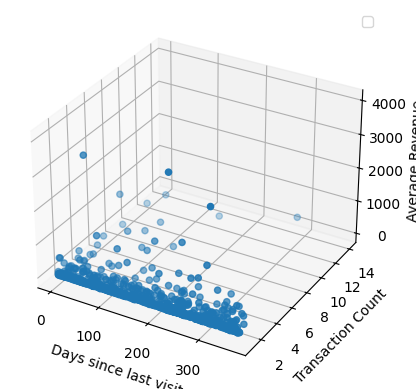

In [45]:
# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.scatter(df['daysSinceLastVisit'], df['transactionCount'], df['averageRevenue'], cmap="rainbow")

# Set labels for each axis
ax.set_xlabel('Days since last visit')
ax.set_ylabel('Transaction Count')
ax.set_zlabel('Average Revenue')

# Add a legend (if needed)
ax.legend()

# Show the plot
plt.show()

In [55]:
df.iloc[:,1:4]

,daysSinceLastVisit,transactionCount,averageRevenue
0,66.383750,1,22.990000
1,66.243843,1,70.960000
2,150.706782,12,109.969167
3,191.979630,2,23.230000
4,195.298090,1,68.540000
...,...,...,...
995,233.171759,1,124.970000
996,233.043391,1,48.970000
997,233.053715,1,48.950000
998,233.095752,1,130.450000


In [40]:
# We make KMEANS cluster on Scikitlearn Library.

from sklearn.cluster import KMeans

In [56]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df.iloc[:,1:4])
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

/home/postgres/devel/bqml_palm/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [58]:
cluster_centers

array([[8.10016764e+01, 1.21064815e+00, 5.85924378e+01],
       [1.92601281e+02, 1.33333333e+00, 3.64531833e+03],
       [1.75763965e+02, 1.81690141e+00, 4.18624721e+02],
       [2.68113099e+02, 1.13664596e+00, 6.55240816e+01],
       [1.88142435e+02, 1.90909091e+00, 1.32217074e+03]])

/tmp/ipykernel_26800/1537443106.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(df['daysSinceLastVisit'], df['transactionCount'], df['averageRevenue'], cmap="rainbow")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


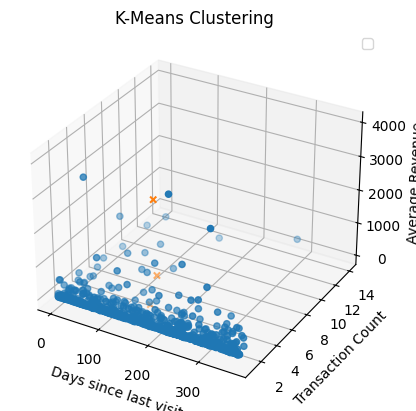

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.scatter(df['daysSinceLastVisit'], df['transactionCount'], df['averageRevenue'], cmap="rainbow")
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], marker='x')

# Set labels for each axis
ax.set_xlabel('Days since last visit')
ax.set_ylabel('Transaction Count')
ax.set_zlabel('Average Revenue')

# Add a legend (if needed)
ax.legend()

# Show the plot
plt.title('K-Means Clustering')
plt.show()

As you can see, Clustering with kmean algortihm can be done with scikit learn library easily. But when you have massive transaction datas, you should use multi-processing (distributed algorithm) to calculate centroids of it. 

So, we will make kmean clustering with BQML.

In [61]:
# To make refined table.
create_sql = ("""
create or replace table {DATASET_ID}.{REFINED_TABLE_NAME} as
""" + sql_refined + """
select daysSinceLastVisit, transactionCount, averageRevenue
from tb_rfm
""").format(DATASET_ID=DATASET_ID,REFINED_TABLE_NAME=REFINED_TABLE_NAME,START_DAY=START_DAY,END_DAY=END_DAY,GA360_TABLE_NAME=GA360_TABLE_NAME)

client.query(create_sql).to_dataframe()


""


In [32]:
def makeModel (n_Clusters, Model_Name):
    sql =f'''
    CREATE OR REPLACE MODEL {DATASET_ID}.{Model_Name} 
    OPTIONS(model_type='kmeans',
    kmeans_init_method = 'KMEANS++',
    num_clusters={n_Clusters}) AS
SELECT * 
    FROM {DATASET_ID}.{REFINED_TABLE_NAME}
    '''.format(DATASET_ID=DATASET_ID, REFINED_TABLE_NAME=REFINED_TABLE_NAME)
    job_config = bigquery.QueryJobConfig()
    client.query(sql, job_config=job_config)

In [66]:
MODEL_NAME = "kmeans_example_cluster5"

makeModel(5, MODEL_NAME)

In [73]:
centroids_query = """
select
  concat('cluster ', cast(centroid_id as string)) as centroid, 
  averageRevenue as average_spend, 
  transactionCount as count_of_orders,
  daysSinceLastVisit as days_since_order
from (
  select centroid_id, feature, round(numerical_value, 2) as value
  from ml.centroids(model `{0}.{1}`)
)
pivot (
  sum(value)
  for feature in ('averageRevenue', 'daysSinceLastVisit', 'transactionCount')
)
order by centroid_id
""".format(DATASET_ID, MODEL_NAME)

df_centroids = client.query(centroids_query).to_dataframe()

In [74]:
df_centroids

,centroid,average_spend,count_of_orders,days_since_order
0,cluster 1,106.23,1.13,269.46
1,cluster 2,16032.75,1.00,318.40
2,cluster 3,324.12,9.49,164.44
3,cluster 4,3338.82,2.17,154.99
4,cluster 5,101.25,1.17,79.69


You can notice that Kmean algorithm are fragile to the abnormal points. For example. list up the centroids value 

| Centroid Id | Count | averageRevenue | daysSinceLastVisit | transactionCount |
|-------------|-------|----------------|--------------------|------------------|
|1|	5,125	|106.2273|269.4567|1.1326|
|2|	1	|16,032.7500|318.4023|1.0000|
|3|	65|324.1187|164.4409|9.4923|
|4|	33	|3,338.8174|154.9932|2.1667|
|5|	4,738	|101.2522|79.6862|1.1695|


Centroid#2 has very unique values. It have only one member who made very big amounts of money in just one event. 
As you know, this Centroid doesn't seem good cluster. 

You can remove this record before to make clsuters.

But now, we just use to make LLM marketing phrases with the above values. 

In [76]:
cluster_info = []
for i, row in df_centroids.iterrows():
    cluster_info.append("{0}, average spend ${1}, count of order per person in one year {2}, days since last order {3}".format(row['centroid'], row['average_spend'], row['count_of_orders'], row['days_since_order']))

print(str.join("\n", cluster_info))


cluster 1, average spend $106.23, count of order per person in one year 1.13, days since last order 269.46
cluster 2, average spend $16032.75, count of order per person in one year 1.0, days since last order 318.4
cluster 3, average spend $324.12, count of order per person in one year 9.49, days since last order 164.44
cluster 4, average spend $3338.82, count of order per person in one year 2.17, days since last order 154.99
cluster 5, average spend $101.25, count of order per person in one year 1.17, days since last order 79.69


In [ ]:
#! pip install google-cloud-aiplatform[preview]

In [62]:
import os

MODEL_ID="text-bison@latest"
PROJECT_NUMBER=os.getenv('PROJECT_NUMBER')
VERTEX_AI_LOCATION="us-central1"

In [81]:
import vertexai
from vertexai.preview.language_models import TextGenerationModel
from google.auth import default

# Without Scopes, you will see the error. 
credentials, _ = default(scopes=["https://www.googleapis.com/auth/cloud-platform"])


vertexai.init(project=PROJECT_NUMBER, location=VERTEX_AI_LOCATION, credentials=credentials)

parameters = {
    "temperature" : 0.2,
    "max_output_tokens" : 32000, 
    "top_p": 0.8, 
    "top_k" : 10
}


In [77]:
model = TextGenerationModel.from_pretrained(MODEL_ID)

In [84]:
GENERATING_MARKETING_PHRASE_PROMPT_TEMPLATE = """
As a smart and creative marketer, give the following clusters, come up with creative brand persona, a catchy title, and next marketing action, explained step by step in Korean.

Clusters :
{clusters}

For each Cluster:
* 타이틀 :
* 페르소나 설명 :
* 마켓팅 방법 : 
"""

clusters = str.join("\n", cluster_info)

print(model.predict(prompt=GENERATING_MARKETING_PHRASE_PROMPT_TEMPLATE.format(clusters=clusters), max_output_tokens=2048))

 **클러스터 1**
* 타이틀: 절약형 소비자
* 페르소나 설명: 이 클러스터는 평균 지출이 106.23달러로 가장 낮은 편입니다. 연간 주문 횟수는 1.13회로 거의 주문하지 않으며, 마지막 주문 이후 경과된 날짜는 269.46일로 가장 깁니다. 이들은 불필요한 지출을 줄이고 돈을 절약하는 것을 중요하게 생각하는 사람들입니다.
* 마케팅 방법: 이 클러스터를 타겟팅하기 위해서는 저렴한 가격과 할인 혜택을 강조하는 것이 좋습니다. 또한, 제품의 품질과 내구성을 강조하여 장기적으로 비용을 절약할 수 있음을 알려주는 것도 효과적입니다.

**클러스터 2**
* 타이틀: 고급 지출가
* 페르소나 설명: 이 클러스터는 평균 지출이 16032.75달러로 가장 높은 편입니다. 연간 주문 횟수는 1.0회로 거의 주문하지 않지만, 마지막 주문 이후 경과된 날짜는 318.4일로 길지 않습니다. 이들은 돈을 아끼지 않고 자신이 원하는 것을 사는 것을 좋아하는 사람들입니다.
* 마케팅 방법: 이 클러스터를 타겟팅하기 위해서는 고급스럽고 프리미엄감 있는 제품을 강조하는 것이 좋습니다. 또한, 제품의 품질과 브랜드 가치를 강조하여 다른 제품과 차별화하는 것도 효과적입니다.

**클러스터 3**
* 타이틀: 충성 고객
* 페르소나 설명: 이 클러스터는 평균 지출이 324.12달러로 보통 수준입니다. 연간 주문 횟수는 9.49회로 가장 많으며, 마지막 주문 이후 경과된 날짜는 164.44일로 짧습니다. 이들은 특정 브랜드나 제품에 충성도가 높고 자주 구매하는 사람들입니다.
* 마케팅 방법: 이 클러스터를 타겟팅하기 위해서는 로열티 프로그램이나 회원제를 제공하는 것이 좋습니다. 또한, 신제품 출시나 할인 혜택 등에 대한 정보를 정기적으로 제공하여 고객의 충성도를 유지하는 것도 효과적입니다.

**클러스터 4**
* 타이틀: 쇼핑狂
* 페르소나 설명: 이 클러스터는 평균 지출이 3338.82달러로 두 번째로 높은 편입니다. 연간 주문 횟수는 2.17회로 보통 수준이며, 마지막 주문 이후 